In [4]:
#!pip install tf-keras -q

In [3]:
!pip install peft datasets transformers trl accelerate bitsandbytes -q


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!nvidia-smi

Sun Aug 11 04:57:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:1A:00.0 Off |                  N/A |
| 29%   24C    P8              1W /  250W |       1MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch
import json
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, PeftModelForCausalLM
from trl import SFTTrainer
from datasets import Dataset
from huggingface_hub import notebook_login, login
import pandas as pd
from tqdm import tqdm
import re

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-11 04:57:32.951639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 04:57:32.971734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 04:57:32.977696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-11 04:57:32.993656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to 

In [6]:
save_path = "./jssp/data/"
dataset_train_name = 'Schedule_Data_Train'
dataset_val_name = 'Schedule_Data_Val'
file_name_train_chatml = f"{dataset_train_name}_chatml.json"
file_name_val_chatml = f"{dataset_val_name}_chatml.json"


with open(save_path + file_name_train_chatml, 'r') as f:
  dataset_train = Dataset.from_dict(json.load(f))

with open(save_path + file_name_val_chatml, 'r') as f:
  dataset_val = Dataset.from_dict(json.load(f))


In [7]:
from huggingface_hub import login
login(token = "...") # add huggingface token for your account

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [8]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_compute_dtype=torch.float16,
)

In [9]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it")
tokenizer.padding_side = 'right'

In [10]:
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2b-it",
    device_map="auto",
    quantization_config=bnb_config
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


In [11]:
peft_config = LoraConfig(
    lora_alpha = 32,
    lora_dropout=0.5,
    r=16,
    task_type='CAUSAL_LM'
)

In [15]:
training_run = "./training/"
training_arguments = TrainingArguments(
    output_dir = training_run,
    eval_strategy="steps",
    logging_strategy="steps",
    lr_scheduler_type="constant",
    logging_steps=10,
    eval_steps=10,
    save_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=16,
    eval_accumulation_steps=16,
    num_train_epochs=4,
    fp16=True,
    group_by_length = True,
    optim="paged_adamw_32bit",
    max_steps = 90
)

In [16]:
trainer = SFTTrainer(
    model,
    tokenizer=tokenizer,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    peft_config=peft_config,
    neftune_noise_alpha=5,
    max_seq_length=500,
    args = training_arguments
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': neftune_noise_alpha, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:310: UserWarning: You passed a `neftune_noise_alpha` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:366: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you passed will overri

In [17]:
train_history = trainer.train()

Step,Training Loss,Validation Loss
10,0.161200,2.301210
20,0.138700,2.022703
30,0.115200,1.763633
40,0.098400,1.591062
50,0.085500,1.466854
60,0.072700,1.365783
70,0.058800,1.272545
80,0.043100,1.237641
90,0.027400,1.246087


In [19]:
print(train_history)

TrainOutput(global_step=90, training_loss=0.08899921145704058, metrics={'train_runtime': 35.4784, 'train_samples_per_second': 324.705, 'train_steps_per_second': 2.537, 'total_flos': 535606456320000.0, 'train_loss': 0.08899921145704058, 'epoch': 90.0})


In [20]:
model_gemma_2b_it_ft_path = "./jssp/model_gemma_2b_it/"
trainer.model.save_pretrained(model_gemma_2b_it_ft_path)

In [21]:
gemma_2b_ft = PeftModelForCausalLM.from_pretrained(model=model, model_id=model_gemma_2b_it_ft_path)

In [17]:
"""
def extract_python_code(markdown_text):
    # Regular expression pattern for a Python code block in Markdown
    # This pattern looks for both ```python and ``` followed by the code block
    pattern = r'```(?:python)?\s*(.*?)```'

    # Use re.DOTALL to match across multiple lines
    matches = re.findall(pattern, markdown_text, re.DOTALL)

    # If code blocks are found, join them; otherwise, return the entire text assuming it's Python code
    if matches:
        # Join matches in case there are multiple code blocks
        python_code = '\n\n'.join(matches)
    else:
        # If no markdown code blocks are detected, assume the entire text is Python code
        python_code = markdown_text

    return python_code
"""

In [26]:
import re  
  
def extract_python_code(markdown_text):  
    # Regular expression pattern for a Python code block in Markdown  
    # This pattern looks for both ```python and ``` followed by the code block  
    pattern = r'```(?:python)?\s*(.*?)\s*```'  
      
    # Use re.DOTALL to match across multiple lines  
    matches = re.findall(pattern, markdown_text, re.DOTALL)  
      
    # If code blocks are found, join them; otherwise, return the entire text assuming it's Python code  
    if matches:  
        # Join matches in case there are multiple code blocks  
        python_code = '\n\n'.join(matches)  
    else:  
        # If no markdown code blocks are detected, assume the entire text is Python code  
        python_code = markdown_text  
      
    # Split the text by <eos> and take the first part  
    python_code = python_code.split('<eos>')[0]  
      
    return python_code  


In [27]:
data_test = pd.read_csv("./jssp/data/results_analysis6.csv")

# Add a new column to the DataFrame for storing responses
data_test['pf_gemma_2b_ft'] = None

# Define the number of iterations in your loop
total_iterations = len(data_test)

# Use tqdm to create a progress bar
progress_bar4 = tqdm(total=total_iterations, desc='Processing', unit='iteration')


for index, row in data_test.iterrows():
    prob_desc = row["Description"]
    messages=[
    {
        'role':'user',
        'content':prob_desc,
    }
    ]
    input_ids = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=True, return_tensors="pt")
    input_ids = input_ids.to('cuda')
    model_output = gemma_2b_ft.generate(input_ids=input_ids, max_new_tokens=2048, do_sample=False)
    response = tokenizer.decode(model_output[0]).split('<start_of_turn>model\n')[-1]
    prob_form = extract_python_code(response)
    data_test.at[index, 'pf_gemma_2b_ft'] = prob_form
    progress_bar4.update(1)

progress_bar4.close()

Processing: 100%|██████████| 20/20 [07:05<00:00, 21.26s/iteration]


In [28]:
# write the updated DataFrame to a new CSV file
data_test.to_csv("./jssp/data/results_analysis6.csv", index=False)

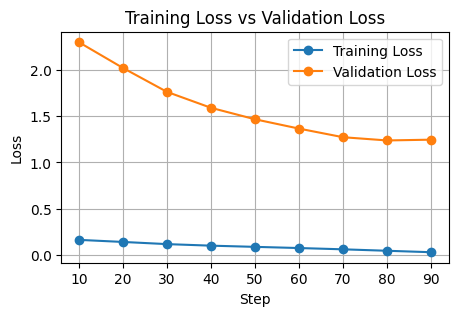

In [30]:
import matplotlib.pyplot as plt  
  
# Provided data  
steps = [10, 20, 30, 40, 50, 60, 70, 80, 90]  
training_loss = [0.161200, 0.138700, 0.115200, 0.098400, 0.085500, 0.072700, 0.058800, 0.043100, 0.027400]  
validation_loss = [2.301210, 2.022703, 1.763633, 1.591062, 1.466854, 1.365783, 1.272545, 1.237641, 1.246087]  
  
# Create the plot  
plt.figure(figsize=(5, 3))  
plt.plot(steps, training_loss, label='Training Loss', marker='o')  
plt.plot(steps, validation_loss, label='Validation Loss', marker='o')  
  
# Add titles and labels  
plt.title('Training Loss vs Validation Loss')  
plt.xlabel('Step')  
plt.ylabel('Loss')  
plt.legend()  
  
# Show grid  
plt.grid(True)  
  
# Display the plot  
plt.show()